In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

/home/icb/cabright61/anaconda3/envs/thesis/lib/python3.8/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
import os
import pickle
import mplscience
import scarches as sca
import matplotlib.pyplot as plt
import seaborn as sns
from velovi import VELOVI

 captum (see https://github.com/pytorch/captum).
/home/icb/cabright61/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/seed.py:48: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
INFO:lightning_lite.utilities.seed:[rank: 0] Global seed set to 0
/home/icb/cabright61/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/loggers/base.py:24: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  rank_zero_deprecation(


In [6]:
#Choose dataset
dataset = "dentategyrus"

if dataset == "pbmc":
    cell_column = 'celltype'
elif dataset == "pancreas":
    cell_column = 'clusters'
elif dataset == "dentategyrus":
    cell_column = 'clusters'
elif dataset == "hindbrain":
    cell_column = 'Celltype'

#Choose model to train
model = "divelo"

if model =="hivelo":
    use_ontology=True

In [7]:
if model =="hivelo":
    adata_file = "data/" + dataset + "/" + "processed_ontology.h5ad"
else:
    adata_file = "data/" + dataset + "/" + dataset + "_data_annotations.h5ad" #preprocessed data
adata_output = "data/" + dataset + "/" + model + "/" + "data_output.h5ad" #path so save output adata after training model
metrics_dict = "output/" + dataset + "/" + model + "/latent_analysis.pkl"

In [ ]:
adata=sc.read(adata_file)
vae=VELOVI.load("trained_models/" + dataset + "/" + model, adata)

In [ ]:
#Analyse granule mature cells

#train model

In [11]:
def compute_sign_variance(adata, vae):
    v_stack = vae.get_velocity(n_samples=50, velo_statistic="mean", return_mean=False)
    pos_freq = (v_stack >= 0).mean(0)
    # neg_freq = (v_stack < 0).mean(0)

    adata.layers["velocity"] = v_stack.mean(0)

    var_freq = pos_freq * (1 - pos_freq)
    adata.obs["sign_var"] = var_freq.mean(1)

    adata.layers["sign_var"] = var_freq
    adata.layers["variance"] = v_stack.var(0)

def compute_sign_var_score(adata, labels_key, vae):
    compute_sign_variance(adata, vae)

    sign_var_df = adata.to_df("sign_var")
    expr_df = adata.to_df("Ms")

    prod_df = sign_var_df * np.abs(expr_df)
    prod_df[labels_key] = adata.obs[labels_key]
    prod_df = prod_df.groupby(labels_key).mean()

    sign_var_df[labels_key] = adata.obs[labels_key]
    sign_var_df = sign_var_df.groupby(labels_key).mean()

    # max over clusters for a gene
    return sign_var_df.mean(0)

def gene_rank(adata, vkey="velocity"):
    from scipy.stats import rankdata
    scv.tl.velocity_graph(adata, vkey=vkey)
    tm = scv.utils.get_transition_matrix(
        adata, vkey=vkey, use_negative_cosines=True, self_transitions=True
    )
    tm.setdiag(0)
    adata.layers["Ms_extrap"] = tm @ adata.layers["Ms"]
    adata.layers["Ms_delta"] = adata.layers["Ms_extrap"] - adata.layers["Ms"]

    prod = adata.layers["Ms_delta"] * adata.layers[vkey]
    ranked = rankdata(prod, axis=1)
    adata.layers["product_score"] = prod
    adata.layers["ranked_score"] = ranked


using n_layers: 1
	with hard mask.
Last Decoder layer: softmax


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/800:  50%|█████     | 400/800 [04:39<04:39,  1.43it/s, loss=-499, v_num=1]
Monitored metric elbo_validation did not improve in the last 80 records. Best score: -454.342. Signaling Trainer to stop.
computing velocity graph (using 1/256 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


using n_layers: 2
	with hard mask.
Last Decoder layer: softmax
Epoch 438/800:  55%|█████▍    | 438/800 [06:04<05:01,  1.20it/s, loss=-490, v_num=1]
Monitored metric elbo_validation did not improve in the last 80 records. Best score: -456.942. Signaling Trainer to stop.
computing velocity graph (using 1/256 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
using n_layers: 3
	with hard mask.
Last Decoder layer: softmax


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 407/800:  51%|█████     | 407/800 [06:31<06:18,  1.04it/s, loss=-458, v_num=1]
Monitored metric elbo_validation did not improve in the last 80 records. Best score: -436.920. Signaling Trainer to stop.
computing velocity graph (using 1/256 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
using n_layers: 4
	with hard mask.
Last Decoder layer: softmax


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 368/800:  46%|████▌     | 368/800 [26:36<31:14,  4.34s/it, loss=-435, v_num=1]    
Monitored metric elbo_validation did not improve in the last 80 records. Best score: -403.628. Signaling Trainer to stop.
computing velocity graph (using 1/256 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


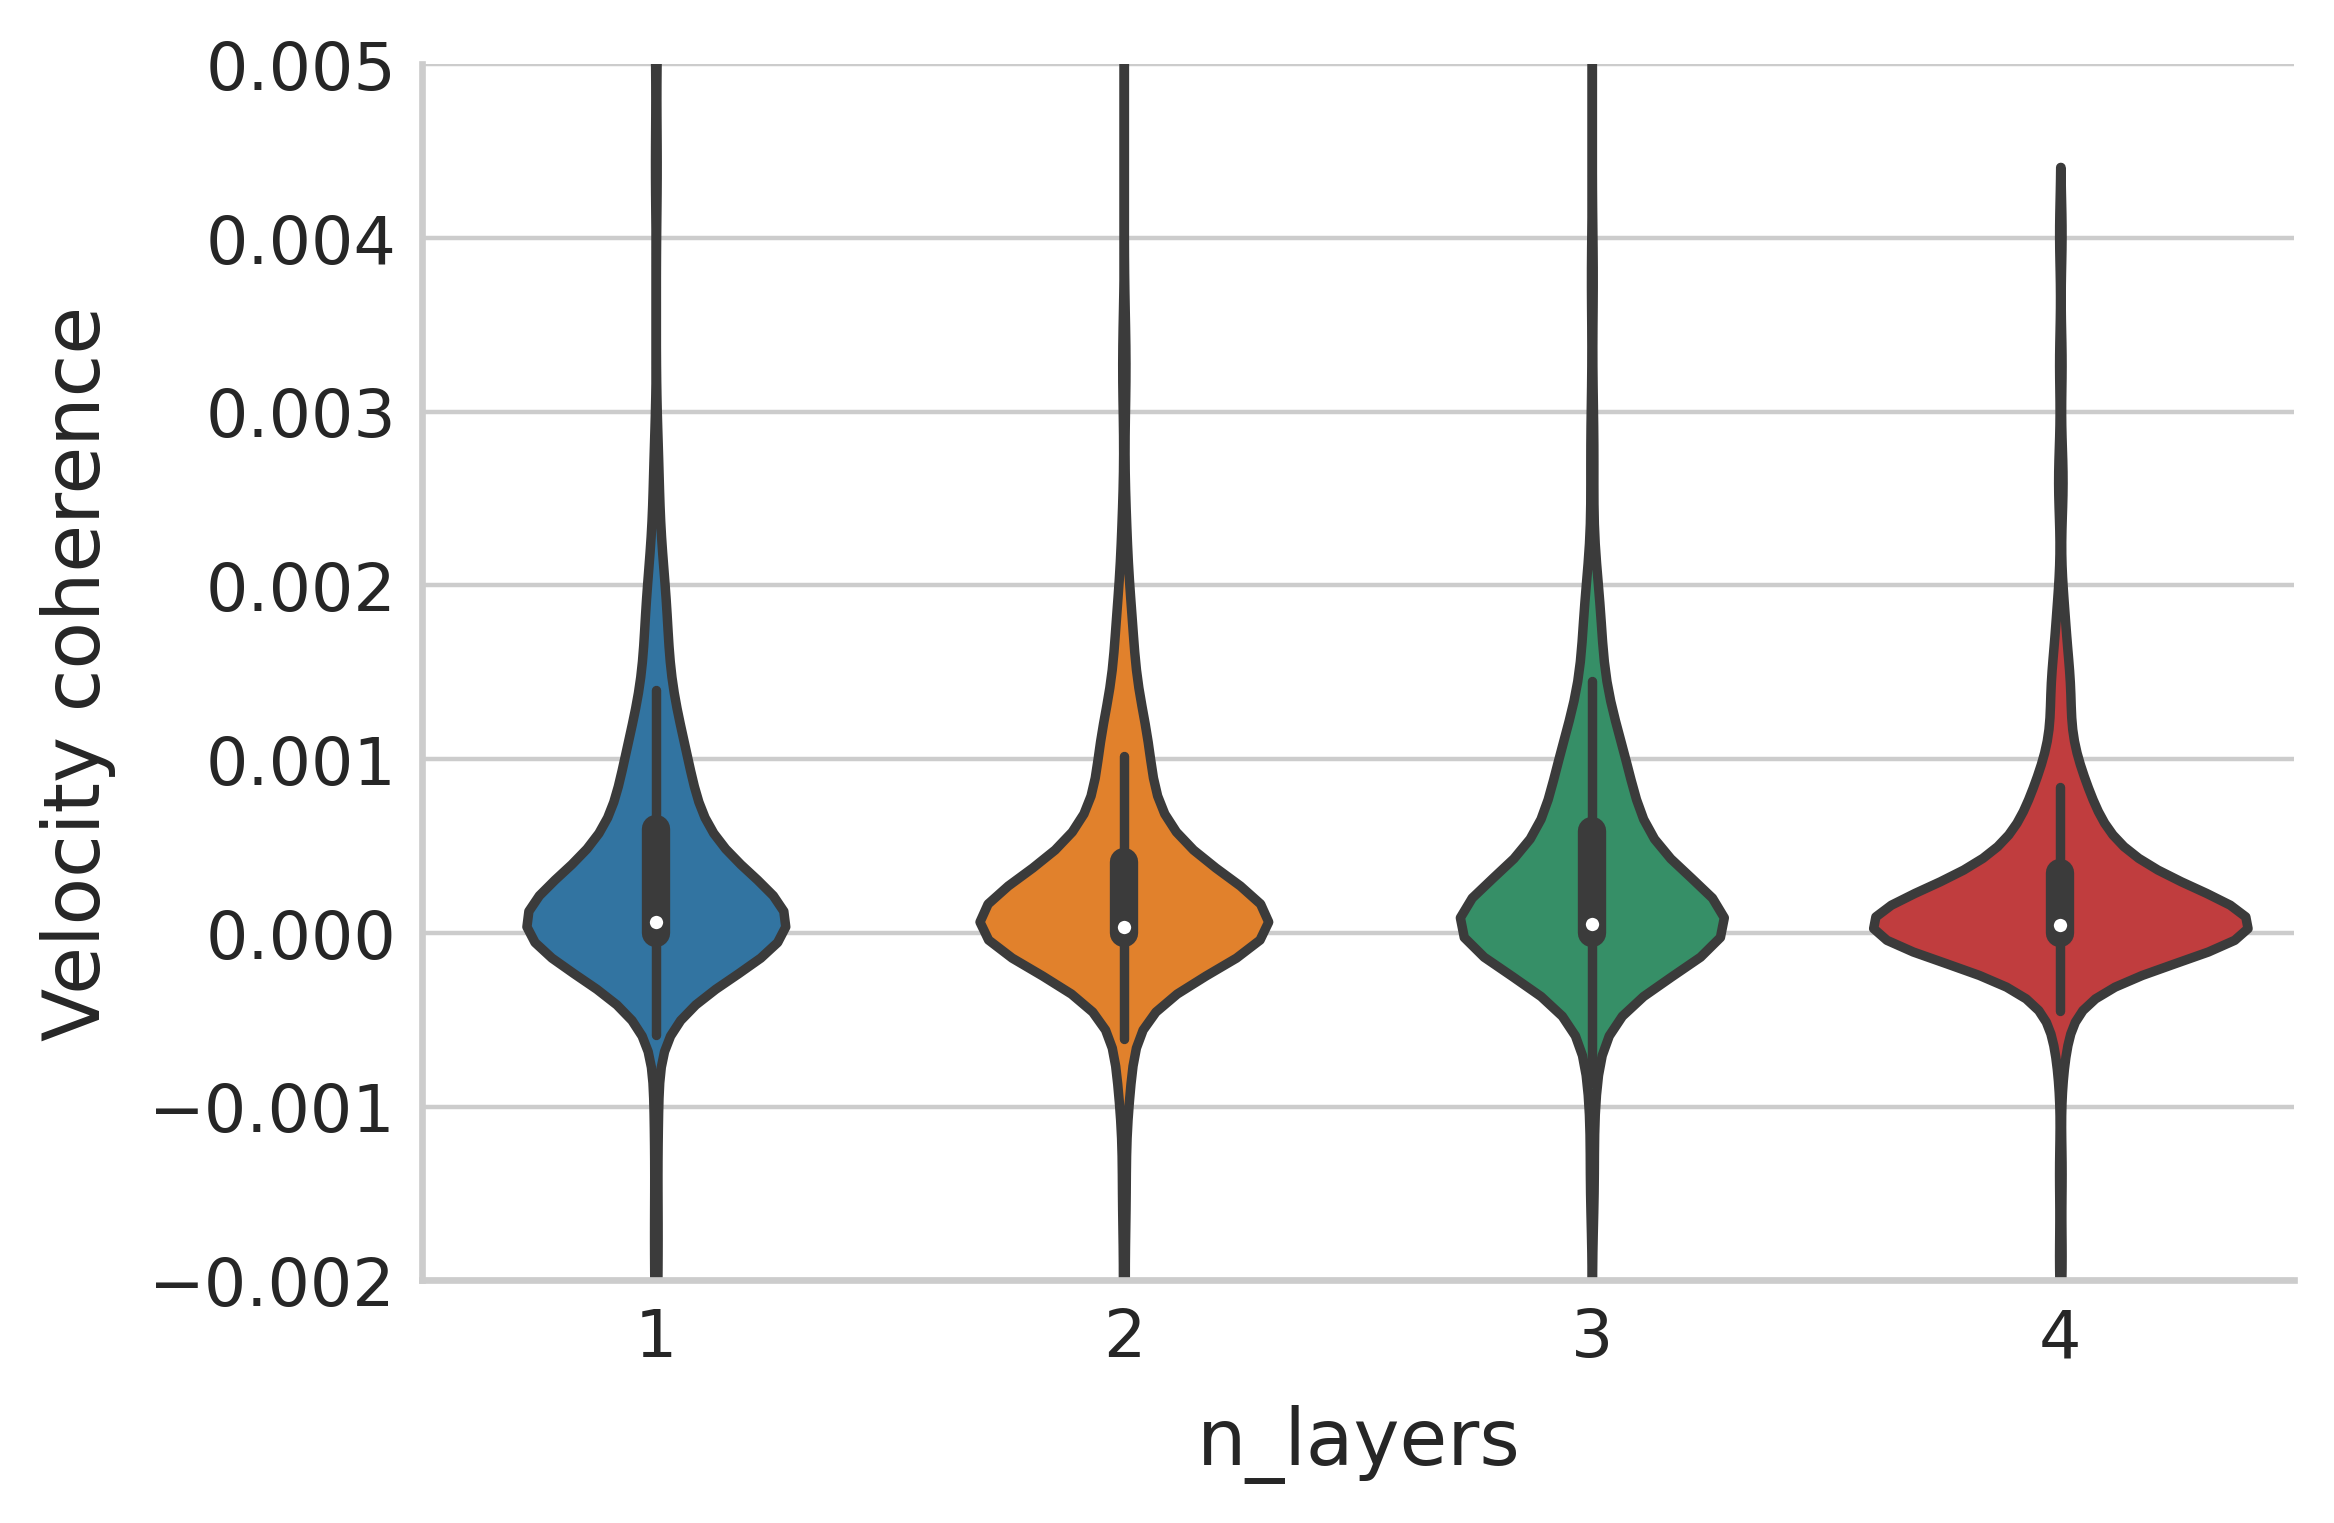

In [44]:
adata = sc.read(adata_file)

adata_train = adata.copy()

config={ "alpha_GP" : 0.8,
        "alpha_kl" : 0.1,
        "batch_size" : 64,
        "dropout_rate" : 0.5,
        "lr" : 0.002,
        "n_hidden" : 128,
        "n_layers" : 3,
        "alpha_gene_recon" : 1,
        "early_stopping_patience":80,
        "alpha_l1" : 0.9
        
       }
#experiment 1
alpha_GP_list=[0.01, 0.06, 0.1, 0.4, 0.8]

#experiment 2
alpha_kl_list=[0.01, 0.06, 0.1, 0.4, 0.8]

#experiment 3
n_hidden_list=[64,128,256,600]

#experiment 4
alpha_l1_list =[0.01, 0.06, 0.1, 0.4, 0.8]

#experiment 5
alpha_gene_recon_list = [4, 8, 12]

n_layers_list = [1,2,3,4]
        

VELOVI.setup_anndata(adata_train, spliced_layer="Ms", unspliced_layer="Mu")

param_name = "n_layers"

param_list = n_layers_list

df = None

omega=None
soft_mask=False

if dataset != "pbmc":
    omega_reactome=torch.ones(adata.varm["I"][:,50:].shape[1])
    omega_panglao=torch.zeros(adata.varm["I"][:,:50].shape[1])
    omega=torch.cat((omega_panglao,omega_reactome))


for param in param_list:
    
    print(f"using {param_name}: {param}")
    vae = VELOVI(
        adata=adata_train,
        n_layers=param, #config["n_layers"],
        dropout_rate=config["dropout_rate"],
        n_hidden=config["n_hidden"],
        soft_mask=soft_mask
    )


    vae.train(
        max_epochs=800,
        lr=config["lr"],
        alpha_GP=config["alpha_GP"],
        omega=omega,
        alpha_l1= config["alpha_l1"] if soft_mask else None,
        alpha_kl= config["alpha_kl"],
        alpha_gene_recon= config["alpha_gene_recon"],
        batch_size=config["batch_size"],
        early_stopping_patience=config["early_stopping_patience"]
    )

    sign_score = compute_sign_var_score(adata, 'clusters', vae)
    gene_rank(adata)


    cell_subset = adata.obs.query("clusters == 'Granule mature'").index
    granule_mature_cluster_data = adata[cell_subset].copy()
    granule_mature_cluster_data.var['mean_product_score_per_gene_granule_mature'] = granule_mature_cluster_data.layers['product_score'].mean(axis=0)


    if df is None:
        df = pd.DataFrame(
                    {
                        'Velocity coherence': granule_mature_cluster_data.var['mean_product_score_per_gene_granule_mature'],
                        param_name: param
                    }
                )
    else:
        df = df.append(pd.DataFrame(
                    {
                        'Velocity coherence': granule_mature_cluster_data.var['mean_product_score_per_gene_granule_mature'],
                        param_name: param
                    }
                ))

sns.set_style("whitegrid")
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.violinplot(data=df, x=param_name, y='Velocity coherence')
    ax.set_ylim([-0.002, 0.005])
    fig.savefig("figures/dentategyrus/"+ model + "/cellwise_coherence_granule_mature_" + param_name + ".png",
                transparent=True,
                bbox_inches='tight')
        



In [45]:
df.groupby([param_name]).mean()

,Velocity coherence
n_layers,
1,0.000391
2,0.000281
3,0.000337
4,0.000245
